Importing necessary libraries

In [108]:
import numpy as np 
from tqdm.notebook import tqdm
import operator
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance
import networkx as nx


Create a Fitness function

In [41]:
class Fitness:
    def __init__(self, population):
        self.population = population
        self.distance = []
    
    def routeDistance(self):
        for i in range(np.shape(self.population)[0]):
          pathDistance = 0
          for j in range(np.shape(self.population)[1]):
              pathDistance += distance.euclidean(self.population[i, j-1], self.population[i, j])
          self.distance.append(pathDistance)
        self.distance = np.asarray(self.distance)
        return self.distance
    
    def routeFitness(self):
        self.fitness = 1 /self.routeDistance()
        return self.fitness

##Create our initial population

Route Generator

In [42]:
def createRoute(cityCoords):
    route = cityCoords[rng.choice(np.shape(cityCoords)[0], np.shape(cityCoords)[0], 0)]
    return route


Create first "population" (array of routes)

In [43]:
def initialPopulation(popSize, cityCoords):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityCoords))
    population = np.asarray(population)
    return population

##Create the genetic algorithm

Rank the routes as per fitness

In [44]:
def rankRoutes(population):
    fitnessDict = {}
    fitnessResults = Fitness(population).routeFitness()
    for i in range(np.shape(fitnessResults)[0]):
      fitnessDict[i] = fitnessResults[i]
    return sorted(fitnessDict.items(), key = operator.itemgetter(1), reverse = True)

Create a selection function that will be used to make the array of parent routes

In [45]:
def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(len(popRanked) - eliteSize):
        pick = 100*rng.random()
        for i in range(len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    selectionResults = np.asarray(selectionResults)
    return selectionResults

Create mating pool

In [46]:
def matingPool(population, selectionResults):
    matingpool = population[selectionResults]
    return matingpool


Create a crossover function for two parents to create one child

In [47]:
def breed(parent1, parent2):
    geneA = int(rng.random() * np.shape(parent1)[0])
    geneB = int(rng.random() * np.shape(parent1)[0])
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    childP1 = parent1[range(startGene, endGene)]

    childP2 = np.asarray([item for item in parent2 if item not in childP1])

    child = np.append(childP1, childP2, axis=0)
    return child

Create function to run crossover over full mating pool

In [48]:
def breedPopulation(matingpool, eliteSize):
    length = np.shape(matingpool)[0] - eliteSize
    pool = matingpool[rng.choice(np.shape(matingpool)[0], np.shape(matingpool)[0], 0)]

    children = matingpool[range(eliteSize)]
    #print(np.shape(children))
    for i in range(0, length):
        child = breed(pool[i], pool[np.shape(matingpool)[0]-i-1])
        #print(np.shape(child))
        #print(np.shape(children))
        children = np.append(children, [child], axis=0)
    return children

Create function to mutate a single route

In [62]:
def mutate(population, mutationRate):
    for swapped in range(np.shape(population)[1]):
        if(rng.random() < mutationRate):
            swapWith = int(rng.random() * np.shape(population)[1])

            population[:, [swapped, swapWith]] = population[:, [swapWith, swapped]]

    return population

Create function to run mutation over entire population

In [50]:
def mutatePopulation(population, mutationRate):
    mutatedPop = mutate(population, mutationRate)
    return mutatedPop


Put all steps together to create the next generation

In [51]:
def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration


Final step: create the genetic algorithm

In [60]:
def geneticAlgorithmPlot(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    progress = []
    progress.append(1 / rankRoutes(pop)[0][1])
    
    for i in tqdm(range(0, generations)):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()
    finalRouteIndex = rankRoutes(pop)[0][0]
    finalRoute = pop[finalRouteIndex]
    return progress, finalRoute

Coordinates taken from the Att48 dataset

In [76]:
cityCoords = np.array([[6734, 1453], [2233,   10], [5530, 1424], [401,  841], [3082, 1644], [7608, 4458], [7573, 3716], [7265, 1268], [6898, 1885],
[1112, 2049], [5468, 2606], [5989, 2873], [4706, 2674], [4612, 2035], [6347, 2683], [6107,  669], [7611, 5184], [7462, 3590], [7732, 4723], [5900, 3561],
[4483, 3369], [6101, 1110], [5199, 2182], [1633, 2809], [4307, 2322],  [675, 1006], [7555, 4819], [7541, 3981], [3177,  756], [7352, 4506], [7545, 2801],
[3245, 3305], [6426, 3173], [4608, 1198], [23, 2216], [7248, 3779], [7762, 4595], [7392, 2244], [3484, 2829], [6271, 2135], [4985,  140], [1916, 1569],
[7280, 4899], [7509, 3239], [10, 2676], [6807, 2993], [5185, 3258], [3023, 1942]])

Create a random generator with seed and run the the algorithm


Final distance: 41240.70667564267


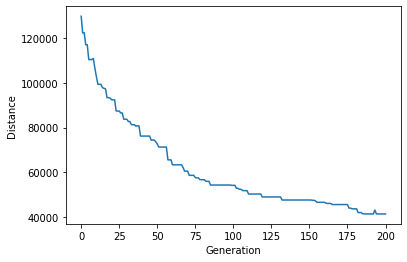

In [99]:
rng = np.random.default_rng(2)
progress, finalRoute = geneticAlgorithmPlot(population=cityCoords, popSize=150, eliteSize=20, mutationRate=0.001, generations=200)

Setting up a graph for visualization

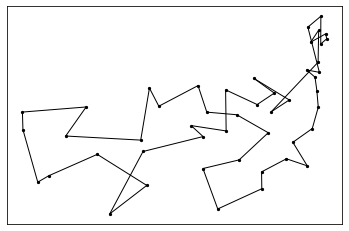

In [114]:
options = {
      'node_color': 'black',
      'node_size': 5,
      'width': 1} 

keys = np.arange(48)
def listOfTuples(l1, l2): 
    return list(map(lambda x, y:(x,y), l1, l2)) 
dictionary_of_coordinates = dict(listOfTuples(keys, listOfTuples(finalRoute[:, 0], finalRoute[:, 1])))
connections = []
for i in range(48):
  connections.append([i, (i+1)%48])

G=nx.Graph()
G.add_edges_from(connections) #define G
list_of_nodes = dictionary_of_coordinates.keys()
pos = nx.spring_layout(G, pos= dictionary_of_coordinates, fixed = list_of_nodes)
nx.draw_networkx(G, pos, with_labels = False, **options)